# Preprocessing 
- variable encoding and transformation
- X/y split
- train/test split
- feature selection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'

#### Features

In [4]:
categorical_feats = {
    "SEX_A": "Sex of Sample Adult", # sex
    "HISPALLP_A": "Single and multiple race groups with Hispanic origin", # race
    "MARITAL_A": "Sample adult's current marital status", # marital status
    "EDUCP_A": "Educational level of sample adult", # education
    "URBRRL": "2013 NCHS Urban-Rural Classification Scheme for Counties", # urban/rural
    "RATCAT_A": "Ratio of family income to poverty threshold for SA's family", # poverty
    "DIBEV_A": "Ever had diabetes",
    "DEPEV_A": "Ever had depression",
    "ANXEV_A": "Ever had anxiety disorder",
    "COPDEV_A": "Ever been told you had COPD, emphysema, or chronic bronchitis?",
    "ARTHEV_A": "Ever had arthritis",
    "DEMENEV_A": "Ever had dementia",
    "HEPEV_A": "Ever had hepatitis",
    "CROHNSEV_A": "Ever had Crohn's disease",
    "ULCCOLEV_A": "Ever had ulcerative colitis",
    "CFSEV_A": "Ever had Chronic Fatigue Syndrome",
    "HLTHCOND_A": "Weakened immune system due to health condition",
    "MEDRXTRT_A": "Weakened immune system due to prescriptions",
    "SHTCVD191_A": "COVID-19 vaccination",
    "SMKCIGST_A": "Cigarette smoking status"
}

mixed_feats = {
    "AGEP_A": "Age of Sample Adult (top-coded)" # age
}

In [5]:
## FEATURE INFORMATION

demographic_info = {
    "AGEP_A": "Age of Sample Adult (top-coded)",
    "SEX_A": "Sex of Sample Adult",
    "HISP_A": "Hispanic ethnicity of Sample Adult",
    "HISPALLP_A": "Single and multiple race groups with Hispanic origin",
    "RACEALLP_A": "Single and multiple race groups",
    "MARITAL_A": "Sample adult's current marital status",
    "SPOUSLIV_A": "Sample adult's spouse lives here",
    "EDUCP_A": "Educational level of sample adult",
    "PCNT18UPTC": "Top-coded count of persons 18 or older in the household",
    "OVER65FLG_A": "Indicator for at least 1 person aged 65+ in Sample Adult family",
    "MLTFAMFLG_A": "Indicator for multifamily households",
    "PCNTKIDS_A": "Number of children in Sample Adult family, top-coded 3+",
    "PARSTAT_A": "Parental Status of sample adult",
    "CEVOLUN1_A": "Volunteer for organization or association",
    "CEVOLUN2_A": "Other volunteer activities",
    "FWIC12M_A": "Receive WIC benefits, past 12 months",
    "INCWRKO_A": "Income from wages"
}

chronic_info = {
    "EVERCOVD_A": "Ever had COVID-19",
    "LONGCOVD1_A": "Had COVID-19 symptoms for 3 or more months",
    # "SYMPNOW1_A": "Currently has COVID-19 symptoms",
    # "LCVDACT_A": "COVID-19 impacts activities",
    "DEPEV_A": "Ever had depression",
    "ANXEV_A": "Ever had anxiety disorder",
    "COPDEV_A": "Ever been told you had COPD, emphysema, or chronic bronchitis?",
    "ARTHEV_A": "Ever had arthritis",
    "DEMENEV_A": "Ever had dementia",
    "DIBTYPE_A": "Diabetes type",
    "HEPEV_A": "Ever had hepatitis",
    "CROHNSEV_A": "Ever had Crohn's disease",
    "ULCCOLEV_A": "Ever had ulcerative colitis",
    "CFSEV_A": "Ever had Chronic Fatigue Syndrome",
    "HLTHCOND_A": "Weakened immune system due to health condition",
    "MEDRXTRT_A": "Weakened immune system due to prescriptions",
    "PAIAMNT_A": "How much pain last time",
    "PAIWKLM3M_A": "How often pain limits life or work",
    "DENPREV_A": "Time since last dental exam or cleaning",
    "DENDL12M_A": "Delayed dental care due to cost, past 12 months",
    "SHTCVD191_A": "COVID-19 vaccination",
    "SHTCVD19NM1_A": "Number of COVID-19 vaccinations",
    "SHOTTYPE2_A": "Brand of first COVID-19 shot",
    "CVDVAC1M1_A": "Month of most recent COVID-19 vaccination",
    "CVDVAC1Y1_A": "Year of most recent COVID-19 vaccination",
    "SHTPNUEV_A": "Ever had pneumonia shot",
    "SHTPNEUNB_A": "Number of pneumonia shots",
    "SHTSHINGL1_A": "Ever had a shingles vaccination"
}

# list of all columns to select
feat_names = list(chronic_info.keys()) + list(demographic_info.keys())

## Preprocess using all features

In [65]:
## USE ALL FEATURES

def preprocess_all_columns(df_full):
    """
    Preprocess all features.  Several assumptions are made:
    - null values of the target (long covid) are dropped
    - features with greater than 8000 missing values are dropped
    - values are imputed before the train test split
    - continuous values are arbitrarily defined
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    scaler = StandardScaler().set_output(transform="pandas")
    scaler = MinMaxScaler().set_output(transform="pandas")
    imputer = SimpleImputer(strategy="constant", fill_value=101).set_output(transform="pandas")
    
    # filter age
    new_df = df_full[df_full["AGEP_A"] <= 84].reset_index(drop=True)
    # filter ys
    # subset for features and drop null values
    df = new_df.dropna(subset=y_name)
    df = df[df[y_name] != 9]
    # drop null columns
    null_cols = df.columns[df.isna().all()].values
    low_counts = df.columns[df.isna().apply(sum) > 8000].values
    df_droppedcols = df.drop(columns=np.hstack((null_cols, low_counts, ['HHX'], y_name)))
    
    # impute values 
    imputed = imputer.fit_transform(df_droppedcols)

    # define continuous and categorical features
    continuous = df_droppedcols.columns[df_droppedcols.apply(np.unique).apply(len) > 15] 
    categorical = df_droppedcols.columns[~df_droppedcols.columns.isin(continuous)]

    # scale and encode
    cont_df =  scaler.fit_transform(imputed.loc[:, continuous])
    cat_df = encoder.fit_transform(imputed.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
    ## END PREPROCESSING
    
    X = processed_df.copy()
    y = df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test

## Preprocess a subset of features

In [7]:
## PIPELINE: preprocess subset features

def preprocess_feature_subset(df_full, categorical_feats):
    """
    Subsets dataframe for categorical_feats + AGE.
    """
    def filter_age(df):
        return df[df["AGEP_A"] <= 84].reset_index(drop=True)
    
    categorical_features = df_full.loc[:, categorical_feats.keys()].columns
    
    # Define preprocessing for the 'age' column
    age_pipeline = Pipeline([
        ('scaler', MinMaxScaler()) ## EDITED
    ])
    
    # categorical columns
    categorical_pipeline = Pipeline([
        ('encoder', OneHotEncoder(drop='first')) 
    ])
    
    # age + categorical pipelines
    full_pipeline = Pipeline([
        # ('filter_age', FunctionTransformer(filter_age)),  # Filter rows with age > 84 or na
        ('preprocessing', ColumnTransformer([
            ('age', age_pipeline, ["AGEP_A"]),
            ('categorical', categorical_pipeline, categorical_features)
        ]))
    ])

    # filter dataframe for relevant targets
    target_df = filter_age(df_full).dropna(subset=y_name)
    target_df = target_df[target_df[y_name] != 9]

    # apply pipeline
    processed_data = full_pipeline.fit_transform(target_df)

    if hasattr(processed_data, "toarray"):  # Check if it's a sparse matrix
        processed_data = processed_data.toarray()
    
    # get feature names from the transformers
    age_feature = ["AGEP_A_scaled"]  # or whatever you want to name the scaled age column
    categorical_feature_names = full_pipeline.named_steps['preprocessing']\
        .transformers_[1][1]\
        .named_steps['encoder']\
        .get_feature_names_out(categorical_features)
    
    feature_names = age_feature + list(categorical_feature_names)
    
    X_processed = pd.DataFrame(processed_data, columns=feature_names)

    # get y
    y = target_df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test

### Alternative feature selection

SCORES ABOVE 50:
Feature FDSCAT4_A_4.0: 134.15588975950797
Feature FDSCAT3_A_3.0: 134.15588975950797
Feature EMERG12MTC_A_4.0: 57.83366063803564
Feature FDSBALANCE_A_2.0: 65.4390447876636
Feature FDSLAST_A_2.0: 72.47892204568376
Feature FDSRUNOUT_A_2.0: 73.15557801784396
Feature BALDIZZ_A_2.0: 68.3533284009751
Feature PAITOOTH3M_A_3.0: 60.32857783762549
Feature PAITOOTH3M_A_101.0: 86.26780959428157
Feature PAIAPG3M_A_3.0: 61.38000434640243
Feature PAIAPG3M_A_101.0: 86.26780959428157
Feature PAIHDFC3M_A_3.0: 163.0427651121782
Feature PAIHDFC3M_A_101.0: 86.26780959428157
Feature PAILLMB3M_A_3.0: 134.63851978253703
Feature PAILLMB3M_A_101.0: 86.26780959428157
Feature PAIULMB3M_A_3.0: 181.59409352242733
Feature PAIULMB3M_A_101.0: 86.26780959428157
Feature PAIBACK3M_A_3.0: 117.88611120031949
Feature PAIBACK3M_A_101.0: 86.26780959428157
Feature PAIAFFM3M_A_2.0: 121.20076329350452
Feature PAIAFFM3M_A_101.0: 86.26780959428157
Feature PAIWKLM3M_A_2.0: 77.32130009735788
Feature PAIWKLM3M_A_3.0: 

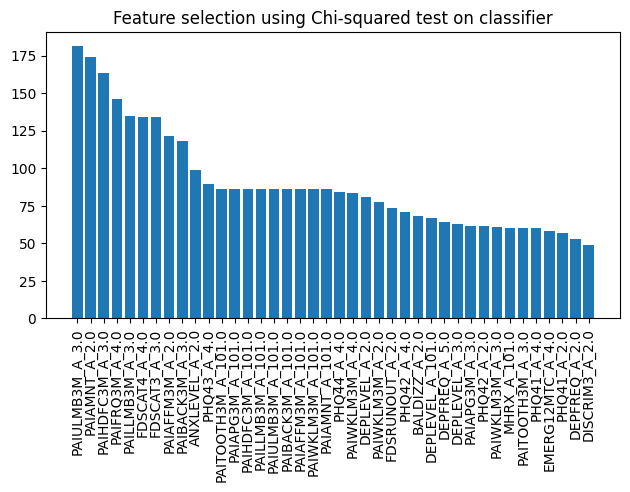

In [84]:
# feature selection
def select_features(X_train, y_train, X_test):
    # perform an imputation to handle missingness
    imputer = SimpleImputer(strategy="constant", fill_value=101)
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.fit_transform(X_test)

    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train_imputed, y_train)
    X_train_fs = fs.transform(X_train_imputed)
    X_test_fs = fs.transform(X_test_imputed)
    return X_train_fs, X_test_fs, fs


def print_top_k_scores(X_train, fs, k=10):
    # what are scores for the features
    print(f"SCORES ABOVE {k}:")
    feats = []
    for i, feat in enumerate(X_train.columns):
        if fs.scores_[i] > k:
            print(f'Feature {feat}: {fs.scores_[i]}')
            feats.append(feat)
    return feats


def plot_feature_scores(X_train, fs):
    topfeats = sorted(zip(X_train.columns,fs.scores_), key=lambda x:x[1], reverse=True)[:40]
    names = [feat[0] for feat in topfeats]
    scores = [feat[1] for feat in topfeats]
    # plot the scores
    fig, ax = plt.subplots()
    # ax.bar(list(X_train.columns), fs.scores_, label=list(X_train.columns))
    ax.bar(names, scores, label=names)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title("Feature selection using Chi-squared test on classifier")
    plt.show()

# feature selection
# X_train, X_test, y_train, y_test = preprocess_feature_subset(df_full, categorical_feats)
X_train, X_test, y_train, y_test = preprocess_all_columns(df_full)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
feats = print_top_k_scores(X_train, fs, k=50)
plot_feature_scores(X_train, fs)

In [82]:
topfeats = sorted(zip(X_train.columns,fs.scores_), key=lambda x:x[1], reverse=True)[:40]

In [88]:
list(set([re.search('(.+)_\d+\.0',feat[0]).group(1) for feat in topfeats]))

['MHRX_A',
 'PAILLMB3M_A',
 'PAIULMB3M_A',
 'FDSCAT3_A',
 'ANXLEVEL_A',
 'PAIWKLM3M_A',
 'EMERG12MTC_A',
 'DISCRIM3_A',
 'PHQ43_A',
 'PHQ44_A',
 'PAIBACK3M_A',
 'PHQ41_A',
 'FDSCAT4_A',
 'FDSRUNOUT_A',
 'BALDIZZ_A',
 'PAIAMNT_A',
 'PAIFRQ3M_A',
 'PHQ42_A',
 'PAIAPG3M_A',
 'DEPFREQ_A',
 'PAITOOTH3M_A',
 'DEPLEVEL_A',
 'PAIAFFM3M_A',
 'PAIHDFC3M_A']

In [90]:
from collections import Counter
Counter([re.search('(.+)_\d+\.0',feat[0]).group(1) for feat in topfeats])

Counter({'PAIWKLM3M_A': 4,
         'DEPLEVEL_A': 3,
         'PAIULMB3M_A': 2,
         'PAIAMNT_A': 2,
         'PAIHDFC3M_A': 2,
         'PAILLMB3M_A': 2,
         'PAIAFFM3M_A': 2,
         'PAIBACK3M_A': 2,
         'PAITOOTH3M_A': 2,
         'PAIAPG3M_A': 2,
         'PHQ42_A': 2,
         'DEPFREQ_A': 2,
         'PHQ41_A': 2,
         'PAIFRQ3M_A': 1,
         'FDSCAT4_A': 1,
         'FDSCAT3_A': 1,
         'ANXLEVEL_A': 1,
         'PHQ43_A': 1,
         'PHQ44_A': 1,
         'FDSRUNOUT_A': 1,
         'BALDIZZ_A': 1,
         'MHRX_A': 1,
         'EMERG12MTC_A': 1,
         'DISCRIM3_A': 1})

- 'MHRX_A', : Took medication for other emotions/concentration/behavior/mental health, past 12 months ***
- 'PAILLMB3M_A', : Pain in hips
-'PAIULMB3M_A', : Pain in hands
- 'FDSCAT3_A', : Adult 3 category food security recode  *** 
- 'ANXLEVEL_A', : Level of feelings when last felt worried/nervous/anxious ***
- 'PAIWKLM3M_A', : How often pain limits life or work ***
- 'EMERG12MTC_A', : Number of times visited hospital emergency room, past 12 months, top-coded ***
- 'DISCRIM3_A', :  Treated as not smart ***
- 'PHQ43_A', : How often felt nervous/anxious/on edge, past 2 weeks
- 'PHQ44_A', :  How often can't stop/control worrying, past 2 weeks
- 'PAIBACK3M_A', : Back pain
- 'PHQ41_A', : How often little interest in things, past 2 weeks
- 'FDSCAT4_A', : Adult 4 category food security recode 
- 'FDSRUNOUT_A', : Worry food would run out
- 'BALDIZZ_A', : Balance or dizziness problem past 12 months *** 
- 'PAIAMNT_A', : How much pain last time
- 'PAIFRQ3M_A', : How often had pain, past 3 months
- 'PHQ42_A', : How often feeling down, past 2 weeks
- 'PAIAPG3M_A', : Abdominal pain
- 'DEPFREQ_A', : How often depressed
- 'PAITOOTH3M_A', : Toothache or jaw pain
- 'DEPLEVEL_A', : Level of how depressed ***
- 'PAIAFFM3M_A', : How often pain impacts family
 -'PAIHDFC3M_A' : Migraine

In [91]:
chi_feats = ['MHRX_A','FDSCAT3_A','ANXLEVEL_A','PAIWKLM3M_A','EMERG12MTC_A','DISCRIM3_A','BALDIZZ_A','DEPLEVEL_A']

In [92]:
feats = chi_feats

encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
y_name = 'LONGCOVD1_A'

# drop rows without target
df = df_full.dropna(subset=y_name)
df = df[df[y_name] != 9]

# Subset to columns
bayes_df = df[feats]

if "HYSTEV2_A" in feats:
    # Assume missing hyterectomy values are 'no'
    bayes_df['HYSTEV2_A'].loc[bayes_df['HYSTEV2_A'].isna()] = 2
    
# Put missing pain into separate category, '101'
bayes_df[bayes_df.isna()] = 101
# Data type: int
bayes_df = bayes_df.astype(int)

if np.any(bayes_df.apply(np.unique).apply(len) > 15):
    scaler = StandardScaler().set_output(transform="pandas")

    X = bayes_df.copy()
    
    # define continuous and categorical features
    continuous = X.columns[X.apply(np.unique).apply(len) > 15] 
    categorical = X.columns[~X.columns.isin(continuous)]
    
    # scale and encode
    cont_df =  scaler.fit_transform(X.loc[:, continuous])
    cat_df = encoder.fit_transform(X.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
else:
    processed_df = encoder.fit_transform(bayes_df)

X = processed_df.copy()
y = df.loc[:, y_name]
y = (y == 1) * 1 # encode as 0 / 1 values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_50091/238479385.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayes_df[bayes_df.isna()] = 101
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_50091/238479385.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayes_df[bayes_df.isna()] = 101


In [106]:
import pymc as pm
import arviz as az
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

In [107]:
coords = {"coeffs":X_train.columns}

with pm.Model(coords=coords) as gen_model:
    # data containers
    X = pm.Data("X", X_train.values)
    y = pm.Data("y", y_train)
    # priors
    b0 = pm.Normal("b0", 0, 100) # intercept: no shrinkage
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = b0 + pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
gen_model


In [96]:
with gen_model:
    idata_gen = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [101]:
az.summary(idata_gen, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[MHRX_A_2],-0.056,0.151,-0.344,0.228,0.002,0.001,7806.0,7922.0,1.0
b[MHRX_A_7],0.493,0.684,-0.773,1.789,0.008,0.005,7777.0,8097.0,1.0
b[MHRX_A_8],-0.308,0.890,-1.946,1.403,0.010,0.007,7921.0,7480.0,1.0
b[MHRX_A_9],-0.183,0.743,-1.590,1.180,0.008,0.006,8012.0,7961.0,1.0
b[MHRX_A_101],0.032,0.155,-0.268,0.315,0.002,0.001,7801.0,7926.0,1.0
b[FDSCAT3_A_2],0.322,0.107,0.134,0.538,0.001,0.001,7894.0,7322.0,1.0
b[FDSCAT3_A_3],0.596,0.113,0.380,0.801,0.001,0.001,8014.0,7905.0,1.0
b[FDSCAT3_A_8],0.022,0.246,-0.426,0.490,0.003,0.002,7895.0,7424.0,1.0
b[ANXLEVEL_A_2],0.267,0.094,0.092,0.447,0.001,0.001,7749.0,7971.0,1.0
b[ANXLEVEL_A_3],0.001,0.069,-0.131,0.128,0.001,0.001,7886.0,7849.0,1.0


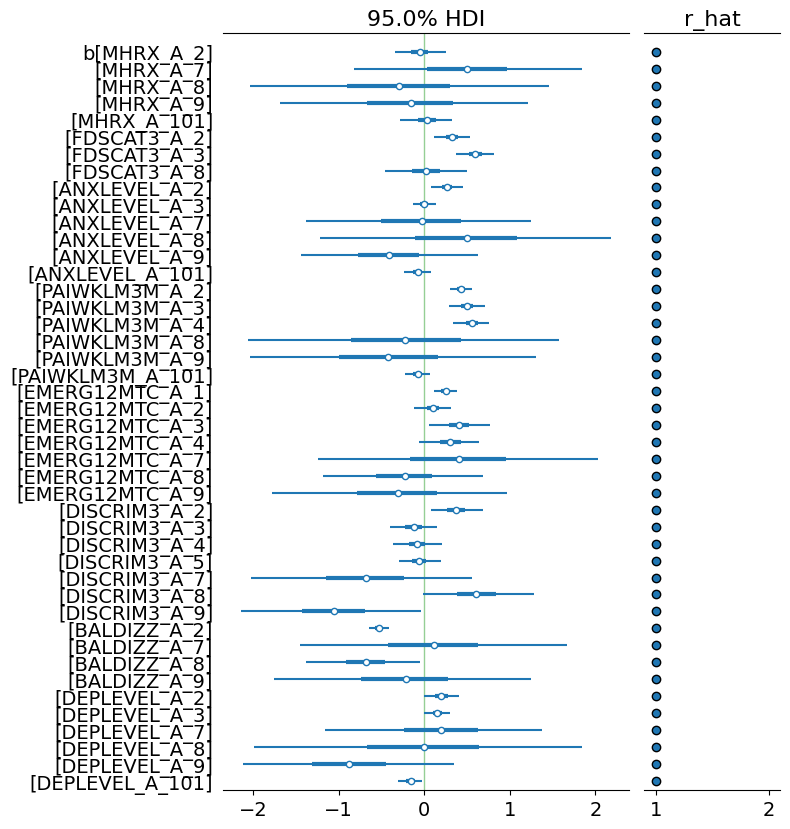

In [102]:
az.plot_forest(idata_gen, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));
plt.tight_layout()

In [103]:
with gen_model:
    pm.set_data({"X": X_test.values, "y": y_test})
    idata_gen.extend(pm.sample_posterior_predictive(idata_gen))

Sampling: [obs]


Output()

In [108]:
def plot_roc(y_true, p_pred, title="ROC"):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots()
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
    x = np.linspace(0,1)
    y = x
    plt.plot(x,y, linestyle='--')
    ax.set(title=title);


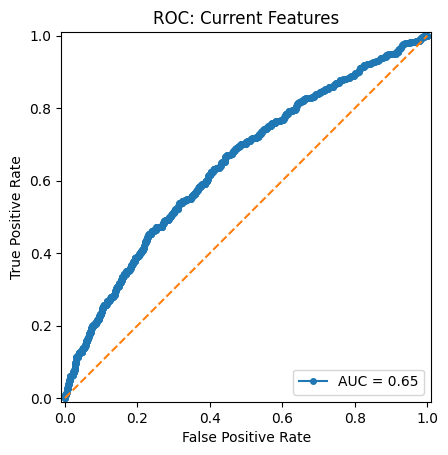

In [109]:
# ROC for general model
p_test_pred = idata_gen.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()

plot_roc(y_test, p_test_pred, title="ROC: Current Features")

In [12]:
def l1_reg_on_all_features():
    """IDENTIFY UNIMPORTANT FEATURES USING ALL VARIABLES"""
    # split X and y, the additional dropped columns do not have any data
    X = df_full.drop(columns=['HHX','LONGCOVD1_A','OGFLG_A', 'OPFLG_A', 
                              'CHFLG_A', 'PRPLCOV2_C_A', 'GALLBAGETC_A', 
                              'CHHDHP_A','CHDEDUC_A', 'CHPREM_A', 'CHXCHNG_A'])
    y = df_full.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=207)
    
    # perform a simple mean imputation to handle missingness
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.fit_transform(X_test)
    
    # create logistic regression with regularization to set coefficients to 0
    lr = LogisticRegression(penalty='l1', solver='liblinear')
    lr.fit(X_train_imputed, y_train)
    print("SCORE:",lr.score(X_test_imputed, y_test))
    
    # record features that were set to 0
    not_zero = ((lr.coef_ >= 0.1)[0] | (lr.coef_ <= -0.1)[0])
    unimportant = X.columns[~not_zero]
    important = X.columns[not_zero]
    
    ## print full list
    # print(", ".join([important[j] for j in range(len(important))]))

    return important, unimportant

In [13]:
important, unimportant = l1_reg_on_all_features()

SCORE: 0.917696867061812


In [14]:
feats = list(important.values)
feats.append(y_name)
test_df = df_full.loc[:,important].loc[:,~df_full.loc[:,important].isna().any()]
test_df[y_name] = df_full[y_name]
test_df = test_df.dropna(subset=y_name)
test_df = test_df[test_df[y_name] != 9]

X = test_df.drop(columns=y_name)
y = test_df.loc[:, y_name]
y = (y == 1) * 1 # encode as 0 / 1 values

encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=207)

lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8519123896698267

In [15]:
pd.DataFrame(important).to_csv("l1reg_important_feats.csv",index=False)

In [16]:
X_train, X_test, y_train, y_test = preprocess_feature_subset(df_full, categorical_feats)

# perform a simple mean imputation to handle missingness
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

# create logistic regression with regularization to set coefficients to 0
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train_imputed, y_train)
lr.score(X_test_imputed, y_test)

0.8399196249162759

In [17]:
# record features that were set to 0
unimportant_idx = ((-0.0001 < lr.coef_) & (lr.coef_ < 0.0001))[0]
unimportant = X_train.columns[unimportant_idx]
important = X_train.columns[~unimportant_idx]
important

Index(['AGEP_A_scaled', 'SEX_A_2', 'HISPALLP_A_2', 'HISPALLP_A_3',
       'HISPALLP_A_4', 'HISPALLP_A_6', 'MARITAL_A_2', 'MARITAL_A_3',
       'MARITAL_A_8', 'EDUCP_A_2', 'EDUCP_A_3', 'EDUCP_A_4', 'EDUCP_A_5',
       'EDUCP_A_6', 'EDUCP_A_7', 'EDUCP_A_8', 'EDUCP_A_9', 'EDUCP_A_10',
       'EDUCP_A_97', 'EDUCP_A_99', 'URBRRL_2', 'URBRRL_3', 'URBRRL_4',
       'RATCAT_A_2', 'RATCAT_A_3', 'RATCAT_A_4', 'RATCAT_A_5', 'RATCAT_A_6',
       'RATCAT_A_8', 'RATCAT_A_9', 'RATCAT_A_10', 'RATCAT_A_11', 'RATCAT_A_13',
       'RATCAT_A_14', 'DIBEV_A_2', 'DEPEV_A_2', 'DEPEV_A_7', 'ANXEV_A_2',
       'ANXEV_A_7', 'ANXEV_A_9', 'COPDEV_A_2', 'ARTHEV_A_2', 'DEMENEV_A_2',
       'HEPEV_A_2', 'CROHNSEV_A_2', 'ULCCOLEV_A_9', 'CFSEV_A_2',
       'HLTHCOND_A_2', 'HLTHCOND_A_9', 'MEDRXTRT_A_2', 'MEDRXTRT_A_9',
       'SHTCVD191_A_2', 'SHTCVD191_A_8', 'SMKCIGST_A_2', 'SMKCIGST_A_4',
       'SMKCIGST_A_9'],
      dtype='object')

In [18]:
for name, score in sorted(zip(X_train.columns, lr.coef_[0]), key=lambda x:np.abs(x[1]), reverse=True):
    if name == 'AGEP_A_scaled':
        descr = mixed_feats["AGEP_A"]
    else:
        descr = categorical_feats[re.sub(r'_[^_]+$', '', name)]
    print(f"{descr} ({name}): {score:.2f}")

Ever had anxiety disorder (ANXEV_A_9): 1.09
Ever had dementia (DEMENEV_A_2): 0.78
Ever had Chronic Fatigue Syndrome (CFSEV_A_2): -0.73
Ever had anxiety disorder (ANXEV_A_7): -0.67
Weakened immune system due to prescriptions (MEDRXTRT_A_9): 0.61
Educational level of sample adult (EDUCP_A_3): 0.57
Educational level of sample adult (EDUCP_A_6): 0.44
Single and multiple race groups with Hispanic origin (HISPALLP_A_4): -0.42
Ever had depression (DEPEV_A_7): -0.42
Ever been told you had COPD, emphysema, or chronic bronchitis? (COPDEV_A_2): -0.40
Educational level of sample adult (EDUCP_A_2): 0.38
Weakened immune system due to health condition (HLTHCOND_A_2): -0.37
Educational level of sample adult (EDUCP_A_5): 0.32
Ever had arthritis (ARTHEV_A_2): -0.31
Ever had diabetes (DIBEV_A_2): -0.30
Ever had depression (DEPEV_A_2): -0.29
Sample adult's current marital status (MARITAL_A_8): -0.29
Ever had anxiety disorder (ANXEV_A_2): -0.28
Weakened immune system due to health condition (HLTHCOND_A_9):

In [19]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'
feat_names = ["AGEP_A", "SEX_A", "SHTCVD191_A", "LONGCOVD1_A"]

# subset for features and drop null values
df = df_full.loc[:, feat_names].dropna(subset=y_name)
df = df[df[y_name] != 9]
print("Shape after feature selection and dropping lcovid nulls:",df.shape)

# FIX ATTRIBUTES
df["SEX_A"] = (df["SEX_A"] == 1) * 1  # 1 is male 
df["SHTCVD191_A"] = (df["SHTCVD191_A"] == 1) * 1  # 1 is yes covid shot

# split X and y
X = df.loc[:, df.columns != y_name]
y = df.loc[:, y_name]
y = (y == 1) * 1 # encode as 0 / 1 values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

# create logistic regression with regularization to set coefficients to 0
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

Shape after feature selection and dropping lcovid nulls: (15291, 4)


0.843085975809088

## AFTER BAYESIAN FEATURE SELECTION

In [20]:
feats = ['PRDEDUC1_A',
 'CITZNSTP_A',
 'VISIONDF_A',
 'BPLAST_A',
 'PCNTADWKP1_A',
 'PAIAFFM3M_A',
 'PHQ43_A',
 'COLORECTEV_A',
 'HEARINGDF_A',
 'SOCWRKLIM_A',
 'ARTHEV_A',
 'VIMREAD_A',
 'ANXFREQ_A',
 'MRIHAD_A',
 'HOUYRSLIV_A',
 'COLOGUARD1_A',
 'CFSEV_A',
 'UPPRAISE_A',
 'CBALHDINJ_A',
 'VIGIL3_A',
 'DISCRIM5_A',
 'DISCRIM1_A',
 'INCWRKO_A',
 'PRDNCOV1_A',
 'NUMCAN_A',
 'FSNAP12M_A',
 'SAPARENTSC_A',
 'CROHNSEV_A',
 'CHLEV_A',
 'VIMDREV_A',
 'PAITOOTH3M_A',
 'COMDIFF_A',
 'PAYBLL12M_A',
 'PRRXCOV1_A',
 'DIFF_A',
 'STREV_A',
 'DISCRIM4_A',
 'PARSTAT_A',
 'EXCHPR1_A',
 'PLNWRKR1_A',
 'FDSBALANCE_A',
 'SHTCVD19NM1_A',
 'CTCOLEV1_A',
 'COGMEMDFF_A',
 'EMPHEALINS_A',
 'PAIHDFC3M_A',
 'MEDICAID_A',
 'ANXEV_A',
 'PCNTADWFP1_A',
 'URGNT12MTC_A',
 'SHTFLUM_A',
 'EMERG12MTC_A',
 'DEPFREQ_A',
 'FDSRUNOUT_A',
 'VIMMDEV_A',
 'AVAIL_A',
 'FDSLAST_A',
 'VIGIL2_A',
 'HOUSECOST_A',
 'DEPMED_A',
 'DEPLEVEL_A',
 'DEPEV_A',
 'ACCSSINT_A',
 'EDUCP_A',
 'INCSSISSDI_A',
 'DISCRIM3_A',
 'MEDICARE_A',
 'VIRAPP12M_A',
 'MEDRXTRT_A',
 'MAMEV_A',
 'VIGIL4_A',
 'MAXEDUCP_A']

In [21]:
# PRINT NUMBER OF RESPONDANTS WITH OR WITHOUT LCOVID

# df_full[y_name].value_counts()
# 12893/2398

# for feat in feats:
#     temp = df[[feat, y_name]]
#     print(f"\nFEATURE: {feat}")
#     print(f"NA VALUES: {temp[feat].isna().sum()}")
#     print(f"LCovid rate: {temp.groupby(by=y_name).sum()[feat].loc[2.0] / temp.groupby(by=y_name).sum()[feat].loc[1.0]}")
#     display(temp.groupby(by=y_name).sum())

In [22]:
# features are all categorical
df = df_full.dropna(subset=y_name)
df = df[df[y_name] != 9]
bayes_df = df[feats].loc[:,~df[feats].isna().any()]
bayes_df.apply(lambda x:x.unique())
bayes_df

,CITZNSTP_A,VISIONDF_A,BPLAST_A,PCNTADWKP1_A,PHQ43_A,HEARINGDF_A,SOCWRKLIM_A,ARTHEV_A,VIMREAD_A,ANXFREQ_A,...,HOUSECOST_A,DEPMED_A,DEPEV_A,ACCSSINT_A,EDUCP_A,DISCRIM3_A,MEDICARE_A,VIRAPP12M_A,MEDRXTRT_A,VIGIL4_A
3,1,1,1,2,1,1,2,2,2,4,...,2,2,2,1,9,5,3,2,2,5
6,1,1,1,2,1,1,2,2,2,4,...,2,2,2,1,8,5,3,1,2,5
7,1,1,1,2,1,1,2,2,1,4,...,2,2,2,1,10,5,3,1,2,5
13,8,1,4,8,1,1,2,2,8,5,...,8,2,2,1,8,5,3,2,2,8
14,8,1,2,8,4,1,2,2,8,1,...,8,1,2,1,8,8,3,2,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29516,1,1,1,1,1,1,1,2,2,2,...,2,2,2,1,9,5,3,2,2,5
29517,1,2,1,0,2,2,1,1,1,1,...,1,2,1,1,5,5,1,2,2,5
29518,1,1,1,2,1,1,2,2,1,3,...,2,1,1,1,7,5,3,2,2,5
29519,1,1,1,0,1,1,2,2,1,2,...,2,2,2,1,8,5,1,2,2,5


In [23]:
## PREPROCESS AFTER BAYES FEATURE SELECTION

def preprocess_after_bayes(df_full):
    """
    Preprocess all features.  Assumptions made:
    - null values of the target (long covid) are dropped
    - features selected from bayes with any null values are dropped
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    
    df = df_full.dropna(subset=y_name)
    df = df[df[y_name] != 9]
    bayes_df = df[feats].loc[:,~df[feats].isna().any()]
    
    cat_df = encoder.fit_transform(bayes_df)
    
    X = cat_df.copy()
    y = df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test

In [28]:

after_second_bayes = ['BALDIZZ_A', # Balance or dizziness problem past 12 months
                      'PAIHDFC3M_A', # Migraine
                      'HRLOUDJOB_A', # Ever exposed to loud noise at job
                      'ASEV_A', # Ever had asthma
                      'SEX_A', # Sex
                      'HYSTEV2_A', # Had hysterectomy
                      'PAIAMNT_A', # How much pain last time, add feature
                      'SHTCVD19NM1_A', # Number of COVID-19 vaccinations
                      # 'PAIWKLM3M_A', # How often pain limits life or work
                      #'EARINFECT_A', 
                      # 'PAYWORRY_A', # Get sick or have accident, worry about paying medical bills
                      # 'DENDL12M_A', # Delayed dental care due to cost, past 12 months
                      # 'MEDDL12M_A', # Delayed medical care due to cost, past 12 months
                      #'PAIAFFM3M_A', 
                      'CFSEV_A', # had chronic fatigue syndrome
                      #'SPOUSEDUCP_A', 
                      # 'EMDSUPER_A', # supervise other employees
                      # 'SHTFLU12M_A', # flu vaccine in last 12 months
                      # 'DENNG12M_A', 
                      # 'PAIULMB3M_A' #pain in hands
                     ]

In [29]:
df_full.loc[:, after_second_bayes].isna().sum()

BALDIZZ_A            0
PAIHDFC3M_A       9675
HRLOUDJOB_A          0
ASEV_A               0
SEX_A                0
HYSTEV2_A        13463
PAIAMNT_A         9675
SHTCVD19NM1_A     5992
CFSEV_A              0
dtype: int64

In [53]:

def preprocess_after_second_bayes(df_full):
    """
    Preprocess all features.  Assumptions made:
    - missing values for hysterectomy are marked 'no hysterectomy'
    - other missing values are put in category '0'
    - all categorical
    """
    feats = ['BALDIZZ_A',
             'PAIHDFC3M_A',
             'HRLOUDJOB_A',
             'ASEV_A',
             'SEX_A',
             'HYSTEV2_A',
             'PAIAMNT_A',
             'SHTCVD19NM1_A',
             'CFSEV_A']
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")

    # drop rows without target
    df = df_full.dropna(subset=y_name)
    df = df[df[y_name] != 9]

    # Subset to columns
    bayes_df = df[feats]
    # Assume missing hyterectomy values are 'no'
    bayes_df['HYSTEV2_A'].loc[bayes_df['HYSTEV2_A'].isna()] = 2
    # Put missing pain into separate category, '0'
    bayes_df[bayes_df.isna()] = 0
    # Data type: int
    bayes_df = bayes_df.astype(int)
    
    
    cat_df = encoder.fit_transform(bayes_df)
    
    X = cat_df.copy()
    y = df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test

In [54]:
X_train, X_test, y_train, y_test = preprocess_after_second_bayes(df_full)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_50091/2436650160.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bayes_df['HYSTEV2_A'].loc[bayes_df['HYSTEV2_A'].isna()] = 2
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipy

In [55]:
X_train

,BALDIZZ_A_2,BALDIZZ_A_7,BALDIZZ_A_8,BALDIZZ_A_9,PAIHDFC3M_A_1,PAIHDFC3M_A_2,PAIHDFC3M_A_3,PAIHDFC3M_A_4,PAIHDFC3M_A_7,PAIHDFC3M_A_8,...,SHTCVD19NM1_A_3,SHTCVD19NM1_A_4,SHTCVD19NM1_A_5,SHTCVD19NM1_A_6,SHTCVD19NM1_A_7,SHTCVD19NM1_A_8,SHTCVD19NM1_A_9,CFSEV_A_2,CFSEV_A_7,CFSEV_A_9
4006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7701,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24142,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17695,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11763,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16749,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6687,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4685,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
